# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline. 
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


from sklearn.pipeline import make_pipeline

Then load the data from my Google Drive

In [5]:
'''from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')'''

"from google_drive_downloader import GoogleDriveDownloader as gdd\ngdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',\ndest_path='./data/features.csv')\ngdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',\ndest_path='./data/im/nevus-seg.jpg')\ngdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',\ndest_path='./data/im/nevus.jpg')\ngdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',\ndest_path='./data/im/melanoma-seg.jpg')\ngdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',\ndest_path='./data/im/melanoma.jpg')"

Or from your local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [6]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

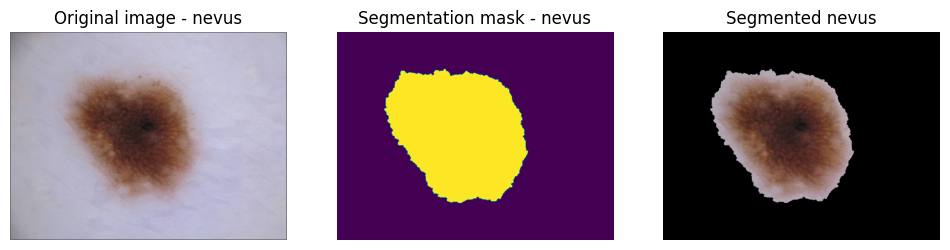

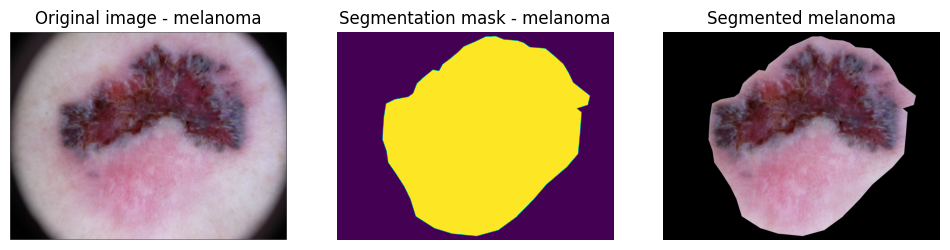

In [7]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [8]:
# Shuffle data randomly
indeces=np.arange(N)
np.random.shuffle(indeces)
Xp=X[indeces]
yp=y[indeces]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

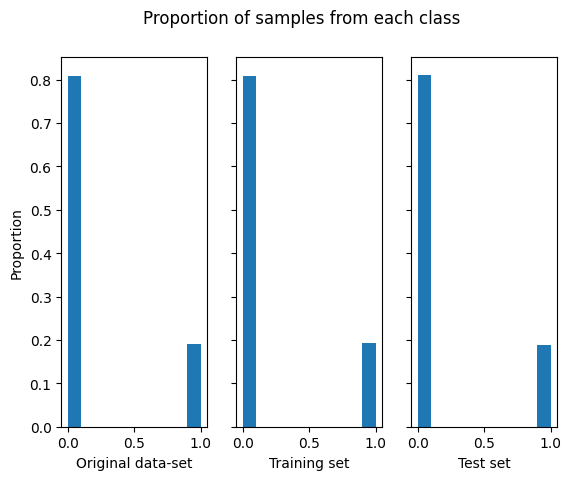

In [9]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

**Answer :**

In our previous session, we emphasized the necessity of applying a standard scaler to our data by fitting it on the `X_train` dataset and then transforming both `X_train` and `X_test` datasets. This practice is crucial to prevent overfitting, ensuring that the model learns to generalize from the training data rather than memorizing its specific characteristics. By fitting the scaler only on the training data, we maintain the integrity of the model's ability to perform well on unseen data, adhering to best practices in machine learning for optimal model performance.

In [12]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       146
           1       0.48      0.32      0.39        34

    accuracy                           0.81       180
   macro avg       0.67      0.62      0.64       180
weighted avg       0.78      0.81      0.79       180

Normalized confusion matrix
[[0.91780822 0.08219178]
 [0.67647059 0.32352941]]


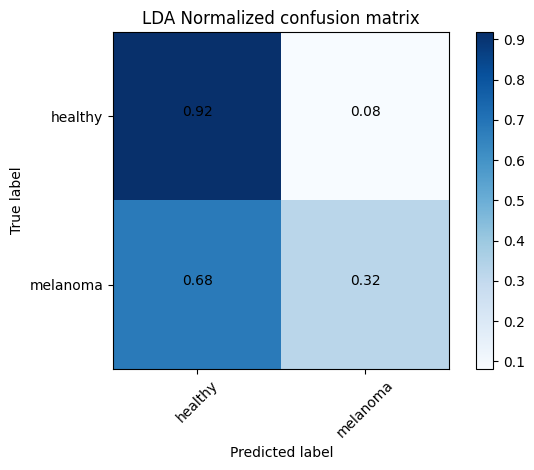

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       146
           1       0.58      0.32      0.42        34

    accuracy                           0.83       180
   macro avg       0.72      0.63      0.66       180
weighted avg       0.80      0.83      0.81       180

Normalized confusion matrix
[[0.94520548 0.05479452]
 [0.67647059 0.32352941]]


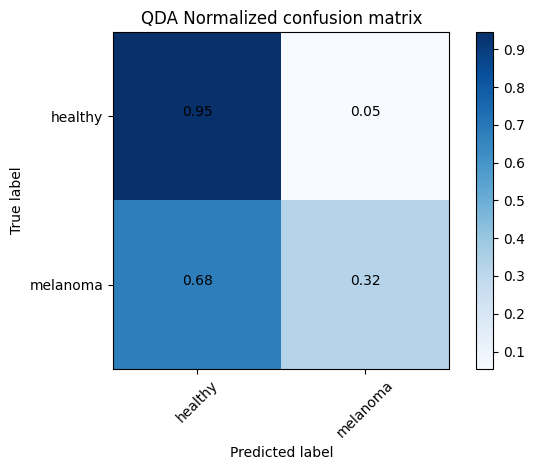

In [13]:
# Fitting LDA
print("Fitting LDA to training set")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting LDA to training set")
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

**Answer :**

The results indicate that QDA performs slightly better in correctly identifying healthy cases but shows no improvement in identifying melanoma cases compared to LDA. Both models seem to struggle with a high false negative rate for the 'melanoma' class, which is particularly concerning in medical diagnostics as it represents a high rate of missed diagnoses for this serious condition. It might be beneficial to look into improving the sensitivity of these models, perhaps by gathering more data, feature engineering, or trying different classification algorithms.

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

**Answer :**

We use cross-validation.

In [14]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda, Xp, yp, cv=5)
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))


# Fitting QDA
print("Fitting QDA")
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda, Xp, yp, cv=5)
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting K-nearest neighbour
print("Fitting KNN")
knn = KNeighborsClassifier(n_neighbors=5)
knn_score = cross_val_score(knn, Xp, yp, cv=5)
print(" Average and std CV score : {0} +- {1}".format(knn_score.mean(), knn_score.std() ))

Fitting LDA
 Average and std CV score : 0.8183333333333334 +- 0.013333333333333336
Fitting QDA
 Average and std CV score : 0.8033333333333333 +- 0.020138409955990935
Fitting KNN
 Average and std CV score : 0.7816666666666666 +- 0.026034165586355542


---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. 

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

---

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8380952380952381
Best training params: {'kneighborsclassifier__n_neighbors': 8}
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.79411765 0.20588235]]


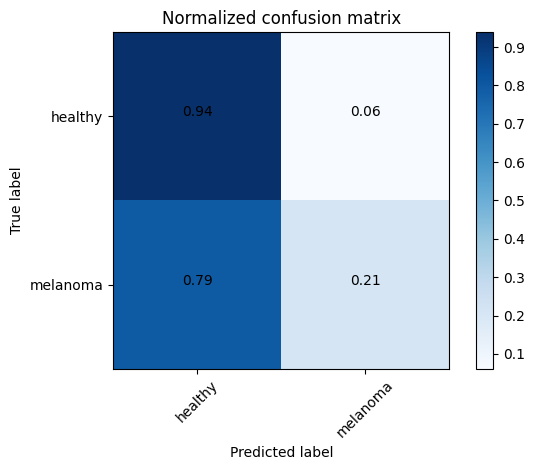

In [15]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Answer :**

The confusion matrix for the KNN classifier shows a high accuracy for identifying 'healthy' individuals but a low accuracy for detecting 'melanoma'. This discrepancy could be due to imbalanced data, an inappropriate choice of the 'K' parameter, insufficient feature distinction, skewed distance metrics due to feature scale, or the presence of noise and outliers. To address this, one could balance the classes, fine-tune the 'K' value, improve feature representation, adjust the distance metric, and clean the dataset to improve classification performance, particularly for the 'melanoma' class where the model currently shows a high rate of false negatives.

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

Best training Score: 0.6414124231782264
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.82876712 0.17123288]
 [0.55882353 0.44117647]]


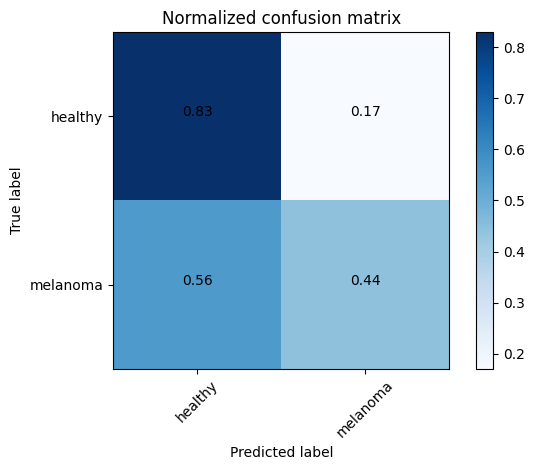

In [19]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="balanced_accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage. 

**Answer :**

Oversampling involves creating additional copies of instances from the underrepresented class, in this case, the 'melanoma' class, to equalize the number of observations across different classes in the dataset.

In [18]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 350)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

Best training Score: 0.870845234317148
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.66438356 0.33561644]
 [0.5        0.5       ]]


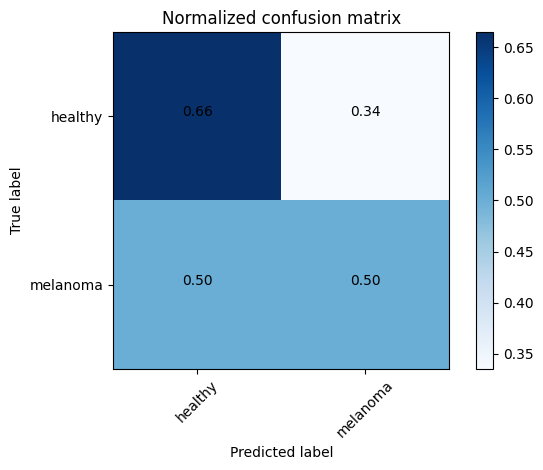

In [20]:
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Answer :**

The outcomes have improved marginally; we now observe fewer instances of incorrect classifications as compared to correct ones. The enhanced results are not influenced by the choice of scoring metric, which can be attributed to the fact that the two classes are now equally represented in the dataset.

Let's use the techniques seen today: Perceptron and linear SVM. 

In [21]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7716666666666667 +- 0.022461386619905925
 Average and std TEST CV accuracy : 0.7533333333333334 +- 0.018708286933869715
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8462500000000001 +- 0.00549621081594703
 Average and std TEST CV accuracy : 0.8233333333333335 +- 0.021343747458109498


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [22]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7716666666666667 +- 0.022461386619905925
 Average and std TEST CV accuracy : 0.7533333333333334 +- 0.018708286933869715
 Average and std TRAIN CV f1 : 0.3811338000816512 +- 0.07920657648127982
 Average and std TEST CV f1 : 0.3346693766937669 +- 0.07201390029752396
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8458333333333334 +- 0.005590169943749454
 Average and std TEST CV accuracy : 0.825 +- 0.018257418583505554
 Average and std TRAIN CV f1 : 0.4289554857964301 +- 0.020902153725174427
 Average and std TEST CV f1 : 0.36832089735315543 +- 0.07496468135390202


**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)


**Answer :**

The performance metrics have declined when using the resampled dataset.

In [23]:
from imblearn.pipeline import make_pipeline as make_pipeline2 

# Fitting Perceptron on resampled data
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Fitting linear SVM on resampled data
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6254166666666666 +- 0.07573024128077531
 Average and std TEST CV accuracy : 0.5833333333333333 +- 0.08366600265340757
 Average and std TRAIN CV f1 : 0.4033306829832478 +- 0.04085899714152766
 Average and std TEST CV f1 : 0.33721885275104996 +- 0.030151484988849602
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7587499999999999 +- 0.009718253158075467
 Average and std TEST CV accuracy : 0.72 +- 0.04102844541697059
 Average and std TRAIN CV f1 : 0.5235261686823041 +- 0.016245385110975577
 Average and std TEST CV f1 : 0.44605931414843764 +- 0.047505152479654304


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.699404761904762 +- 0.03398595815147667
 Average and std TEST CV accuracy : 0.6523809523809525 +- 0.04351349257737398
 Average and std TRAIN CV f1 : 0.4754169140811831 +- 0.005991202465671404
 Average and std TEST CV f1 : 0.3967670041143959 +- 0.03076641928958693
Normalized confusion matrix
[[0.74657534 0.25342466]
 [0.61764706 0.38235294]]


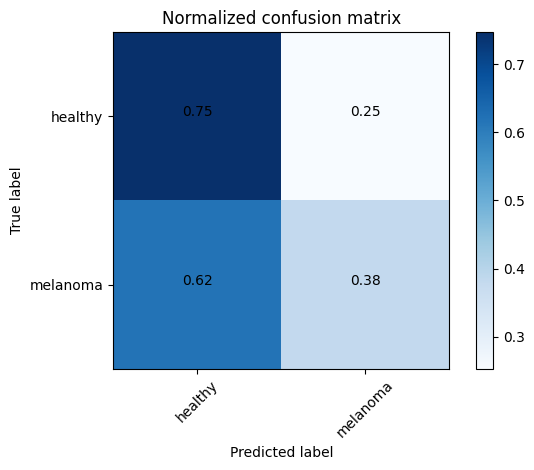

Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7541666666666667 +- 0.011230929919114991
 Average and std TEST CV accuracy : 0.7095238095238094 +- 0.03883215816738114
 Average and std TRAIN CV f1 : 0.5396236476516136 +- 0.017171640261450516
 Average and std TEST CV f1 : 0.4567838150726802 +- 0.04145825513460852
Normalized confusion matrix
[[0.68493151 0.31506849]
 [0.44117647 0.55882353]]


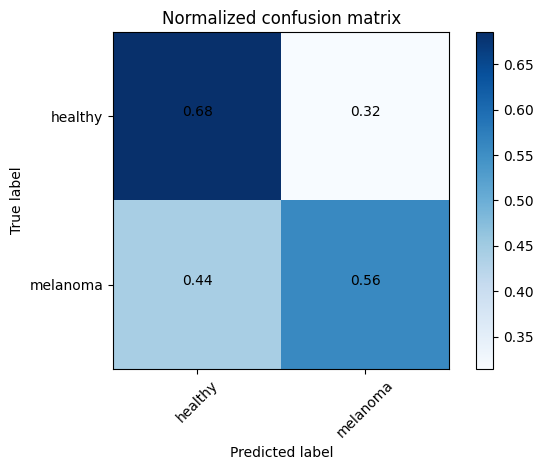

In [24]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.7238095238095239
Best training params: {'linearsvc__C': 0.01}
Normalized confusion matrix
[[0.69178082 0.30821918]
 [0.38235294 0.61764706]]


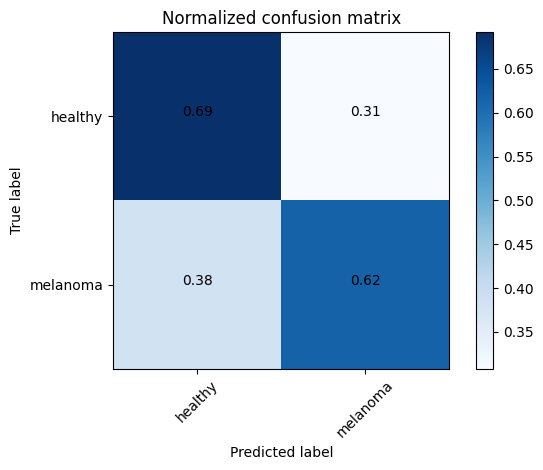

In [25]:
# Looking for the best hyperparameter C 
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix') 
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.8261904761904761
Best training params: {'svc__C': 4, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.9109589  0.0890411 ]
 [0.76470588 0.23529412]]


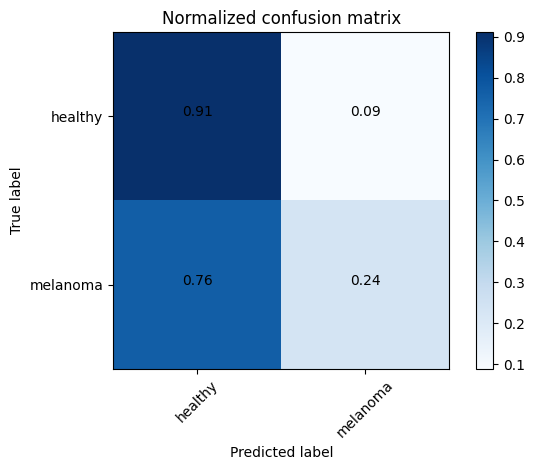

In [26]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf')) 
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

The outcomes remain largely unchanged despite the implementation of both strategies.

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Answer :**

After tuning hyperparameters for SVM models, the performance in classifying 'healthy' individuals improved, but the ability to correctly identify 'melanoma' cases worsened. This could be due to overfitting, non-optimal hyperparameter values, persistent class imbalance despite using ADASYN, or inadequate feature representation for the 'melanoma' class. Further analysis and model refinement are needed to balance the classification performance between classes.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

Best training Score: 0.7095238095238094
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.66438356 0.33561644]
 [0.35294118 0.64705882]]


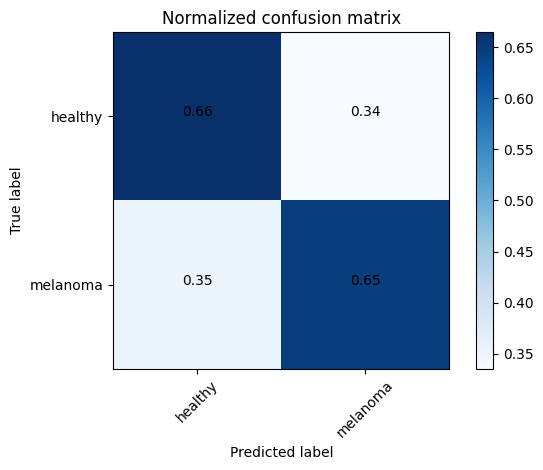

In [27]:
# Test PCA with a linear SVM

Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}

grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

Best training Score: 0.7404761904761905
Best training params: {'svc__C': 0.001, 'svc__gamma': 0.0001}
Normalized confusion matrix
[[0.76027397 0.23972603]
 [0.38235294 0.61764706]]


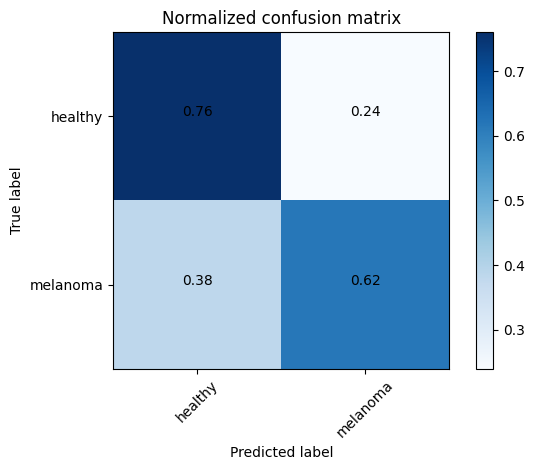

Best training Score: 0.819047619047619
Best training params: {'svc__C': 2, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.88356164 0.11643836]
 [0.76470588 0.23529412]]


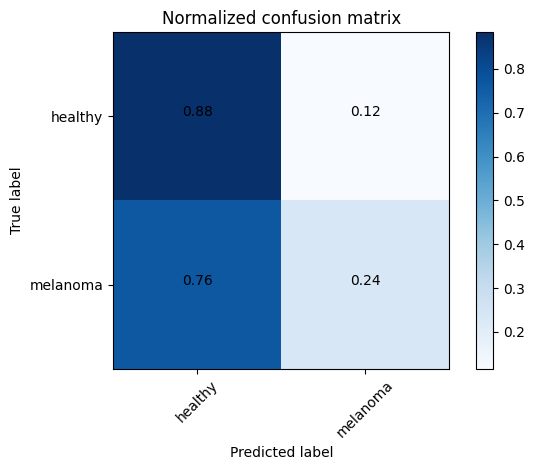

In [28]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), LinearSVC())

# Test PCA with a non-linear SVM

NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), SVC(kernel='linear'))

p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Implement forward feature selection and/or backward feature selection
# with a non-linear SVM

# Test PCA with a non-linear SVM

NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), SVC(kernel='rbf'))

p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()